# Traffic Accident Prediction

This notebook is extra CRISPy used for the Capstone Project for IBM DS Pro Certificate.  It covers -

* Business Understanding: The initial phase is to understand the project's objective from the business or application perspective. Then, you need to translate this knowledge into a machine learning problem with a preliminary plan to achieve the objectives. 
* Data Understanding:  In this phase, you need to collect or extract the dataset from various sources such as csv file or SQL database. Then, you need to determine the attributes (columns) that you will use to train your machine learning model. Also, you will assess the condition of chosen attributes by looking for trends, certain patterns, skewed information, correlations, and so on. 
* Data Preparation:  The data preparation includes all the required activities to construct the final dataset which will be fed into the modeling tools. Data preparation can be performed multiple times and it includes balancing the labeled data, transformation, filling missing data, and cleaning the dataset. 
* Modeling:  In this phase, various algorithms and methods can be selected and applied to build the model including supervised machine learning techniques. You can select SVM, XGBoost, decision tree, or any other techniques. You can select a single or multiple machine learning models for the same data mining problem. At this phase, stepping back to the data preparation phase is often required. 
* Evaluation:  Before proceeding to the deployment stage, the model needs to be evaluated thoroughly to ensure that the business or the applications' objectives are achieved. Certain metrics can be used for the model evaluation such as accuracy, recall, F1-score, precision, and others. 
* Deployment: The deployment phase requirements vary from project to project. It can be as simple as creating a report, developing interactive visualization, or making the machine learning model available in the production environment. In this environment, the customers or end-users can utilize the model in different ways such as API, website, or so on.


# Business Understanding

TODO - Merge BU section

In [2]:
!conda install -c conda-forge xgboost -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    joblib-0.17.0              |             py_0         204 KB  conda-forge
    libxgboost-1.2.0           |       he1b5a44_0         3.1 MB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    py-xgboost-1.2.0           |   py36h9f0ad1d_0         1.7 MB  conda-forge
    scikit-learn-0.23.2        |   py36hfb379a7_0         6.8 MB  conda-forge
    scipy-1.5.2                |   py36h3a855aa_0        18

In [ ]:
!conda install -c conda-forge imbalanced-learn --y

In [3]:
import pandas as pd
import types
import itertools
import numpy as np
from datetime import timedelta

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import pydotplus
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

# Data Understanding

This project uses accident data from SDOT and is referred to as collisions.  The data is <a href="https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0?geometry=-123.310%2C47.452%2C-121.352%2C47.776">hosted</a> by SDOT GIS Division and curated by the SDOT Traffic Division where collisions are collected from Seattle Police Department after a collision is reported.  Instead of using the full data set this project uses a <a href="https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv">subset</a> of the data provided by Coursera.
<br><br>
General characteristics of the subset -
- Format: CSV
- Timeframe: January 2004 to May 2020
- Columns: 38, 37 are unique
- Rows:  194,673
- Bounding Coordinates
-- West Bounding Coordinate: -122.4754
-- East Bounding Coordinate: -122.2008
-- North Bounding Coordinate: 47.7582
-- South Bounding Coordinate: 47.4814

The subset of the SDOT collision data is used that includes collisions, defined by severity, as property damage, e.g., hitting a parked car, or injury where at least one person involved in the collision was hurt.  The complete data set has additional severities however these are not included which might need to be revisited upon further investigation.
<br><br>
The list below represents the attributes to be considered as independent variables for modeling.  Definitions and data types are defined in the <a href="https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf">SDOT Attribute Dictionary</a>.  Samples are extracted from the Coursera Data Set.  The dependent variable is accident severity, defined as SEVERITYCODE.  There are 37 possible independent variables.  Of the 37 possible 17 were selected as independent variables and are specified in the table.  While the goal is to use date, time, weather, light and road conditions to predict accident severity other attributes are worth exploring and could be beneficial as features to the model.
<br><br>
A significant omission from the potential features is the type of collision.  SDOT uses a state-defined coding scheme that specifies 84 types of collisions including an additional descriptive attribute to further define the code.  While the subset includes these codes and is informative the initial iteration does not include these.  This might need to be revisited based on further investigation.
<br>

For details on all attributes visit the following link -
https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf

Original Data Set - https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0?geometry=-123.310%2C47.452%2C-121.352%2C47.776

Coursera Subset - https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

ESRI Metadata - https://www.arcgis.com/sharing/rest/content/items/5b5c745e0f1f48e7a53acec63a0022ab/info/metadata/metadata.xml?format=default&output=html

*Data-Collisions.csv* attributes with data type, detail and examples as defined in Collision_OD PDF:

- Severity
    - **SEVERITYCODE** - Text,100 - code that corresponds to the severity, e.g., 3—fatality, 2b—serious injury, 2—injury, 1—property damage, 0—unknown
    - **SEVERITYDESC** - Text,300 - Detailed description of the severity, e.g., Property Damage Only Collision, Injury Collision
- Location, Time
    - **INCDATE** - Date - date of the incident, ex: 2013/03/27 00:00:00+00
    - **INCDTTM** - Text,30 - date and time of the incident, ex: 3/27/2013  2:54:00 PM 
    - **X** - float - longitude of the collision
    - **Y** - float - latitude of the collision
    - **LOCATION** - Text,255 - description of the general location of the collision, e.g. 5TH AVE NE AND NE 103RD ST
    - **ADDRTYPE** - Text,12 -  collision address type, e.g, alley, block, intersection
    - **JUNCTIONTYPE** - Text,300 - category of junction where the collision occurred. e.g., At Intersection (intersection related)
    - **INTKEY** - Double - key corresponding to the intersection associated with a collision 
    - **CROSSWALKKEY** - Long - key for the crosswalk at which the collision occurred 
- Situational Conditions
    - **WEATHER** - Text,300 - weather condition, e.g., Clear, Overcast, Raining, Snowing 
    - **ROADCOND** - Text,300 - road condition, e.g., Wet, Dry
    - **LIGHTCOND** - Text,300 - light condition, e.g., Daylight, Dark, Dark - Street Lights On
- Counts
    - **VEHCOUNT** - Double - number of vehicles involved in the collision
    - **PERSONCOUNT** - Double - total number of people involved in the collision 
    - **PEDCOUNT** - Double - number of pedestrians involved in the collision 
    - **PEDCYLCOUNT** - Double - number of bicycles involved in the collision
- Human Factors
    - **INATTENTIONIND** - Text,1 - whether or not collision was due to inattention (Y/N) 
    - **UNDERINFL** - Text,1 - whether or not a driver involved was under the influence of drugs or alcohol 
- Collision Descriptors
    - **COLLISIONTYPE** - Text,300 - collision type, e.g., Angle, Sideswipe, Parked Car
    - **SPEEDING** - Text,1 - whether or not speeding was a factor in the collision (Y/N) 
    - **SEGLANEKEY** - Long - key for the lane segment in which the collision occurred 
    - **HITPARKEDCAR** - Text,1 - whether or not the collision involved hitting a parked car (Y/N) 
    - **PEDROWNOTGRNT** - Text,1 - whether or not the pedestrian right of way was not granted (Y/N) 
    - **SDOTCOLNUM** - Text, 10 - number given to the collision by SDOT 
    - **SDOT_COLCODE** - Text,10 - code assigned to the collision by SDOT
    - **SDOT_COLDESC** - Text,300 - description corresponding to the collision code 
    - **ST_COLCODE** - Text,10 - code provided by the state that describes the collision 
    - **ST_COLDESC** - Text,300 - description that corresponds to the state’s coding designation 
- Miscellaneous
    - **OBJECTID** - Double - ESRI unique identifier 
    - **INCKEY** - Long - A unique key for the incident 
    - **COLDETKEY** - Long - Secondary key for the incident 
    - **EXCEPTRSNCODE** - Text,10 - undefined 
    - **EXCEPTRSNDESC** - Text,300 - A unique key for the incident 
    - **REPORTNO** - Long - undefined 
    - **STATUS** - Text - undefined 
<br>

Examine the attributes in the context of collision severity.  If it doesn't help us with predicting severity then it's not worth including the attribute in our feature set.

In [4]:
# Read data file from Coursera, not SDOT.  Low memory suppresses warning when loading file, does nothing else
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv",\
                low_memory = False)
#df = pd.read_csv("Collisions-Modified.csv", low_memory = False)
print('File downloaded')

File downloaded


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

In [113]:
df.head(10)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N
5,1,-122.387598,47.690575,6,320840,322340,E919477,Matched,Intersection,36974.0,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
6,1,-122.338485,47.618534,7,83300,83300,3282542,Matched,Intersection,29510.0,...,Wet,Daylight,NaN,8344002.0,NaN,10,Entering at angle,0,0,N
7,2,-122.320780,47.614076,9,330897,332397,EA30304,Matched,Intersection,29745.0,...,Dry,Daylight,NaN,NaN,NaN,5,Vehicle Strikes Pedalcyclist,6855,0,N
8,1,-122.335930,47.611904,10,63400,63400,2071243,Matched,Block,NaN,...,Dry,Daylight,NaN,6166014.0,NaN,32,One parked--one moving,0,0,N
9,2,-122.384700,47.528475,12,58600,58600,2072105,Matched,Intersection,34679.0,...,Dry,Daylight,NaN,6079001.0,NaN,10,Entering at angle,0,0,N


A first look a number of these attributes are system or adminstration related and not really related to the collision.  This includes OBJECTID, REPORTNO, SEVERITYCODE.1, STATUS, EXCEPTRSNCODE, EXCEPTRSNDESC. INCKEY, COLDETKEY, INTKEY, SEGLANEKEY, CROSSWALKKEY all look like keys.

In [6]:
rs = np.random.RandomState(0)
corr = df.corr()
cm = sns.light_palette("green", as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
SEVERITYCODE,1.00,0.01,0.02,0.02,0.02,0.02,0.01,1.00,0.13,0.25,0.21,-0.05,0.19,0.00,0.10,0.18
X,0.01,1.00,-0.16,0.01,0.01,0.01,0.12,0.01,0.01,0.01,-0.00,-0.01,0.01,-0.00,-0.00,0.01
Y,0.02,-0.16,1.00,-0.02,-0.03,-0.03,-0.11,0.02,-0.01,0.01,0.03,0.02,-0.02,-0.01,0.00,0.01
OBJECTID,0.02,0.01,-0.02,1.00,0.95,0.95,0.05,0.02,-0.06,0.02,0.03,-0.09,-0.04,0.97,0.03,0.06
INCKEY,0.02,0.01,-0.03,0.95,1.00,1.00,0.05,0.02,-0.06,0.02,0.03,-0.11,-0.03,0.99,0.02,0.05
COLDETKEY,0.02,0.01,-0.03,0.95,1.00,1.00,0.05,0.02,-0.06,0.02,0.03,-0.11,-0.03,0.99,0.02,0.05
INTKEY,0.01,0.12,-0.11,0.05,0.05,0.05,1.00,0.01,0.00,-0.00,0.00,-0.01,0.01,0.03,-0.01,0.02
SEVERITYCODE.1,1.00,0.01,0.02,0.02,0.02,0.02,0.01,1.00,0.13,0.25,0.21,-0.05,0.19,0.00,0.10,0.18
PERSONCOUNT,0.13,0.01,-0.01,-0.06,-0.06,-0.06,0.00,0.13,1.00,-0.02,-0.04,0.38,-0.13,0.01,-0.02,-0.03
PEDCOUNT,0.25,0.01,0.01,0.02,0.02,0.02,-0.00,0.25,-0.02,1.00,-0.02,-0.26,0.26,0.02,0.00,0.57


In [234]:
# Dropping the columns that are keys and have minimum correlation to severity, leave in lat/long for now
df.drop(columns=['OBJECTID','INCKEY','COLDETKEY','INTKEY','SEVERITYCODE.1'],inplace=True)

## Collision Severity

In [126]:
df.groupby(['SEVERITYDESC'])['SEVERITYCODE'].value_counts()

SEVERITYDESC                    SEVERITYCODE
Injury Collision                2                58188
Property Damage Only Collision  1               136485
Name: SEVERITYCODE, dtype: int64

## Location - Latitude, Longitude

For now do nothing with the coordinates but it is definitely something to consider.  It would be possible to assign these to regions based on neighborhoods to find hotzones.  For now attempt to predict severity without it, can revisit later if time permits.

In [90]:
print(df["X"].value_counts())
print(df["X"].isna().sum())

-122.332653    265
-122.344896    254
-122.328079    252
-122.344997    239
-122.299160    231
              ... 
-122.322768      1
-122.288680      1
-122.405699      1
-122.323578      1
-122.343898      1
Name: X, Length: 23563, dtype: int64
5334


In [91]:
print(df["Y"].value_counts())
print(df["Y"].isna().sum())

47.708655    265
47.717173    254
47.604161    252
47.725036    239
47.579673    231
            ... 
47.556705      1
47.709101      1
47.513899      1
47.565438      1
47.563521      1
Name: Y, Length: 23839, dtype: int64
5334


## Location - Street

There is a lot of information here but there is collision is already geocoded so this seems like it's not worth it.  It seems possible to parse this and do some analysis to help with severity but that is out of scope here.

In [95]:
df['LOCATION'].head()

0                     5TH AVE NE AND NE 103RD ST
1     AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N
2    4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST
3       2ND AVE BETWEEN MARION ST AND MADISON ST
4                SWIFT AVE S AND SWIFT AV OFF RP
Name: LOCATION, dtype: object

## Location - CROSSWALKKEY

Not sure what this is, but a guess is that there is a dictionary of crosswalks for all of Seattle and this would indicate a particular one.  It would be interesting to explore this further because this could indicate a hotzone.

In [111]:
print(df['CROSSWALKKEY'].unique())
print(df['CROSSWALKKEY'].value_counts())

[     0 520838 521466 ... 523792 650595 523322]
0         190862
523609        17
520838        15
525567        13
521707        10
           ...  
521019         1
630862         1
25545          1
523322         1
27186          1
Name: CROSSWALKKEY, Length: 2198, dtype: int64


## Location - ADDRTYPE, JUNCTIONTYPE

For junction type keep At Intersection (intersection related), Mid-Block (not related to intersection), Driveway Junction, and Mid-Block (but intersection related).  For address type only alley doen't have a lot of use.

In [106]:
print(df['ADDRTYPE'].unique())
print(df['ADDRTYPE'].value_counts())

['Intersection' 'Block' 'Alley' nan]
Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64


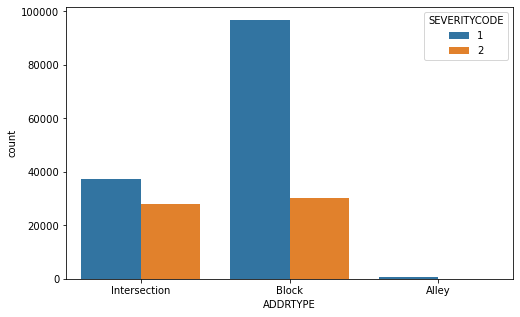

In [16]:
figsize=(8,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="ADDRTYPE", hue="SEVERITYCODE", data=df)

In [108]:
print(df['JUNCTIONTYPE'].unique())
print(df['JUNCTIONTYPE'].value_counts())

['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)' 'Driveway Junction'
 'Mid-Block (but intersection related)'
 'At Intersection (but not related to intersection)' nan 'Unknown'
 'Ramp Junction']
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64


<AxesSubplot:xlabel='JUNCTIONTYPE', ylabel='count'>

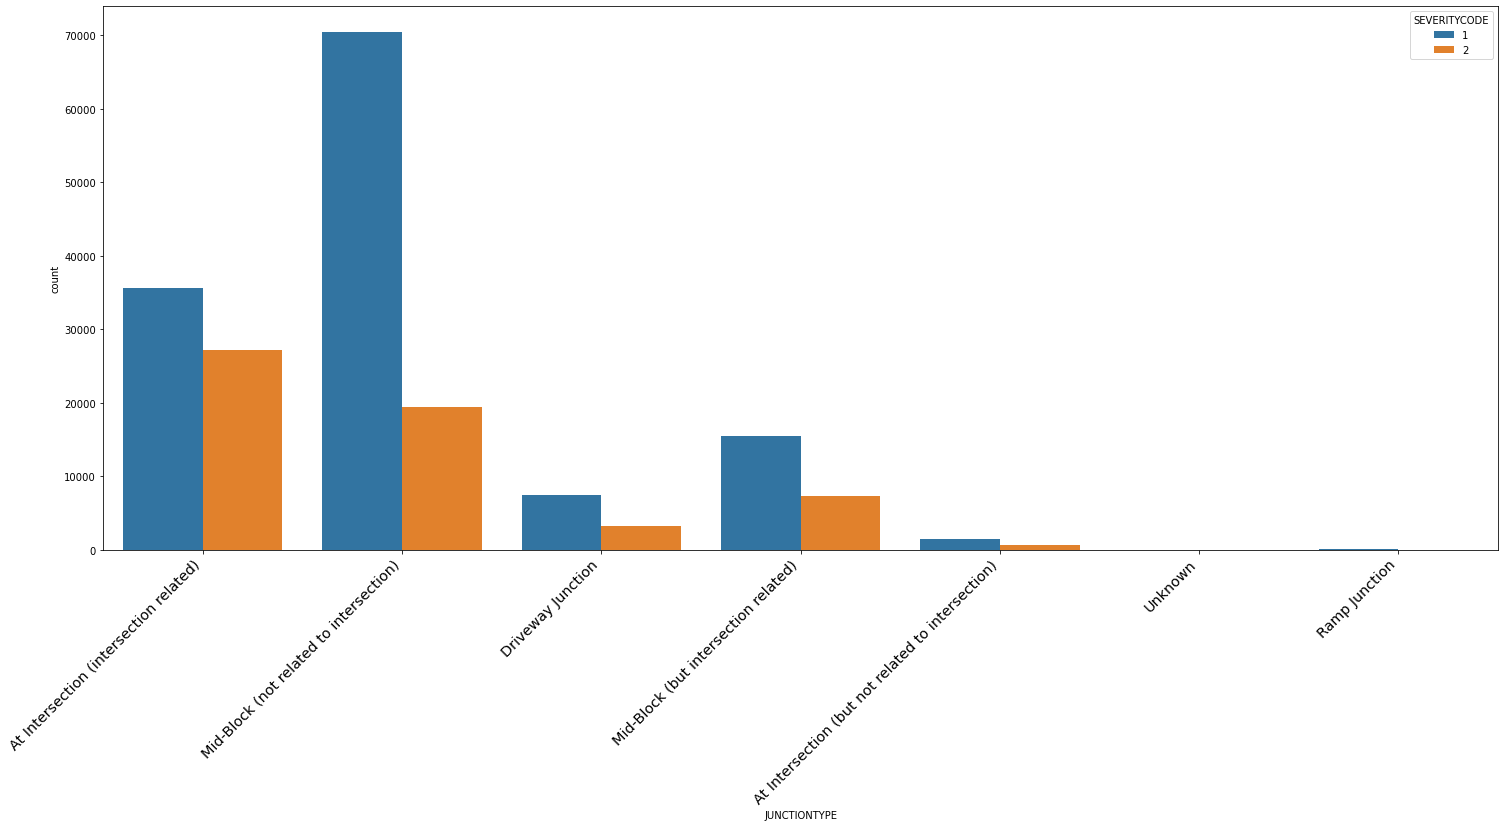

In [15]:
figsize=(25,10)
fig, ax = plt.subplots(figsize=figsize)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
sns.countplot(x="JUNCTIONTYPE", hue="SEVERITYCODE", data=df, ax=ax)

## Collision Date

INCDATE is same as INCDTTM without the time.  So focus on INCDTTM which is in 12h time with merdian.

In [154]:
df[['INCDATE','INCDTTM']].head()

,INCDATE,INCDTTM
0,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM


In [171]:
df_explore = df[['SEVERITYCODE', 'INCDTTM']].copy()
df_explore['INCDTTM'] = pd.to_datetime(df_explore['INCDTTM'])
df_explore.dropna(inplace=True)
df_explore.head()

,SEVERITYCODE,INCDTTM
0,2,2013-03-27 14:54:00
1,1,2006-12-20 18:55:00
2,1,2004-11-18 10:20:00
3,1,2013-03-29 09:26:00
4,2,2004-01-28 08:04:00


In [172]:
def peak_offpeak(inputDate):
    hour = inputDate.hour
    try:
        return 1 if (hour>=8 and hour<=18) else 0
    except:
        return 0

Analysis on the date of the collision.  Check the month, weekday, hour, week in the year.  Check peak or offpeak that would be similar to the workday hours, this might help with generalization but with predicting severity unless something jumps out.

In [173]:
df_explore['MONTH'] = df_explore['INCDTTM'].dt.month
df_explore['WEEKDAY'] = df_explore['INCDTTM'].dt.weekday
df_explore['HOUR'] = df_explore['INCDTTM'].dt.strftime('%H').astype(int)
df_explore['PEAKOROFFPEAK'] = df_explore['INCDTTM'].apply(lambda x: peak_offpeak(x))
df_explore['YEARWEEK'] = df_explore["INCDTTM"].dt.week
df_explore.head()

,SEVERITYCODE,INCDTTM,MONTH,WEEKDAY,HOUR,PEAKOROFFPEAK,YEARWEEK
0,2,2013-03-27 14:54:00,3,2,14,1,13
1,1,2006-12-20 18:55:00,12,2,18,1,51
2,1,2004-11-18 10:20:00,11,3,10,1,47
3,1,2013-03-29 09:26:00,3,4,9,1,13
4,2,2004-01-28 08:04:00,1,2,8,1,5


In [174]:
corr = df_explore.corr()
cm = sns.light_palette("green", as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

,SEVERITYCODE,MONTH,WEEKDAY,HOUR,PEAKOROFFPEAK,YEARWEEK
SEVERITYCODE,1.00,0.00,-0.02,0.03,0.04,0.01
MONTH,0.00,1.00,-0.00,0.01,0.00,0.98
WEEKDAY,-0.02,-0.00,1.00,-0.02,-0.08,-0.00
HOUR,0.03,0.01,-0.02,1.00,0.36,0.03
PEAKOROFFPEAK,0.04,0.00,-0.08,0.36,1.00,0.02
YEARWEEK,0.01,0.98,-0.00,0.03,0.02,1.00


[Text(0.5, 0, 'Collisions'), Text(0, 0.5, 'Peak')]

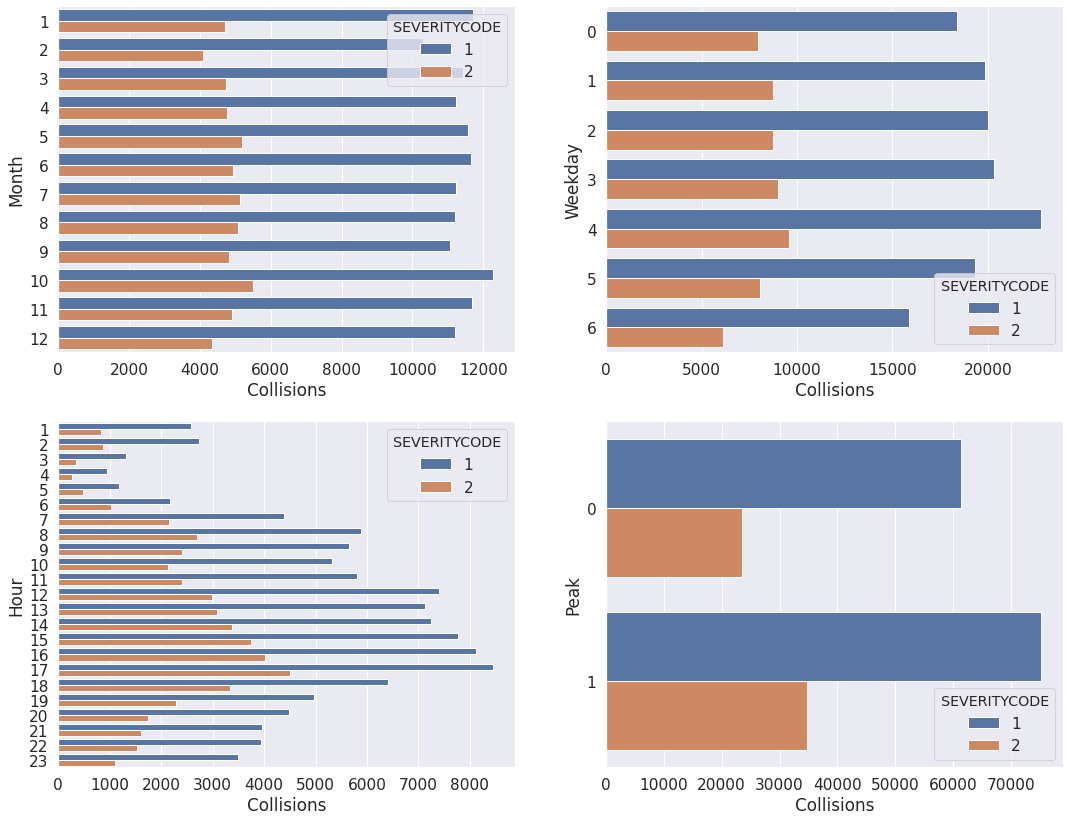

In [215]:
fig, ax = plt.subplots(2,2, figsize = (18, 14))
ax1, ax2, ax3, ax4 = ax.flatten()

sns.countplot(y="MONTH", hue="SEVERITYCODE", data=df_explore, ax=ax1)
ax1.set(xlabel='Collisions', ylabel="Month")

sns.countplot(y="WEEKDAY", hue="SEVERITYCODE", data=df_explore, ax=ax2)
ax2.set(xlabel='Collisions', ylabel="Weekday")

sns.countplot(y="HOUR", hue="SEVERITYCODE", data=df_explore[(df_explore.HOUR != 0)], ax=ax3)
ax3.set(xlabel='Collisions', ylabel="Hour")

sns.countplot(y="PEAKOROFFPEAK", hue="SEVERITYCODE", data=df_explore, ax=ax4)
ax4.set(xlabel='Collisions', ylabel="Peak")

[Text(0.5, 0, 'Collisions'), Text(0, 0.5, 'Week')]

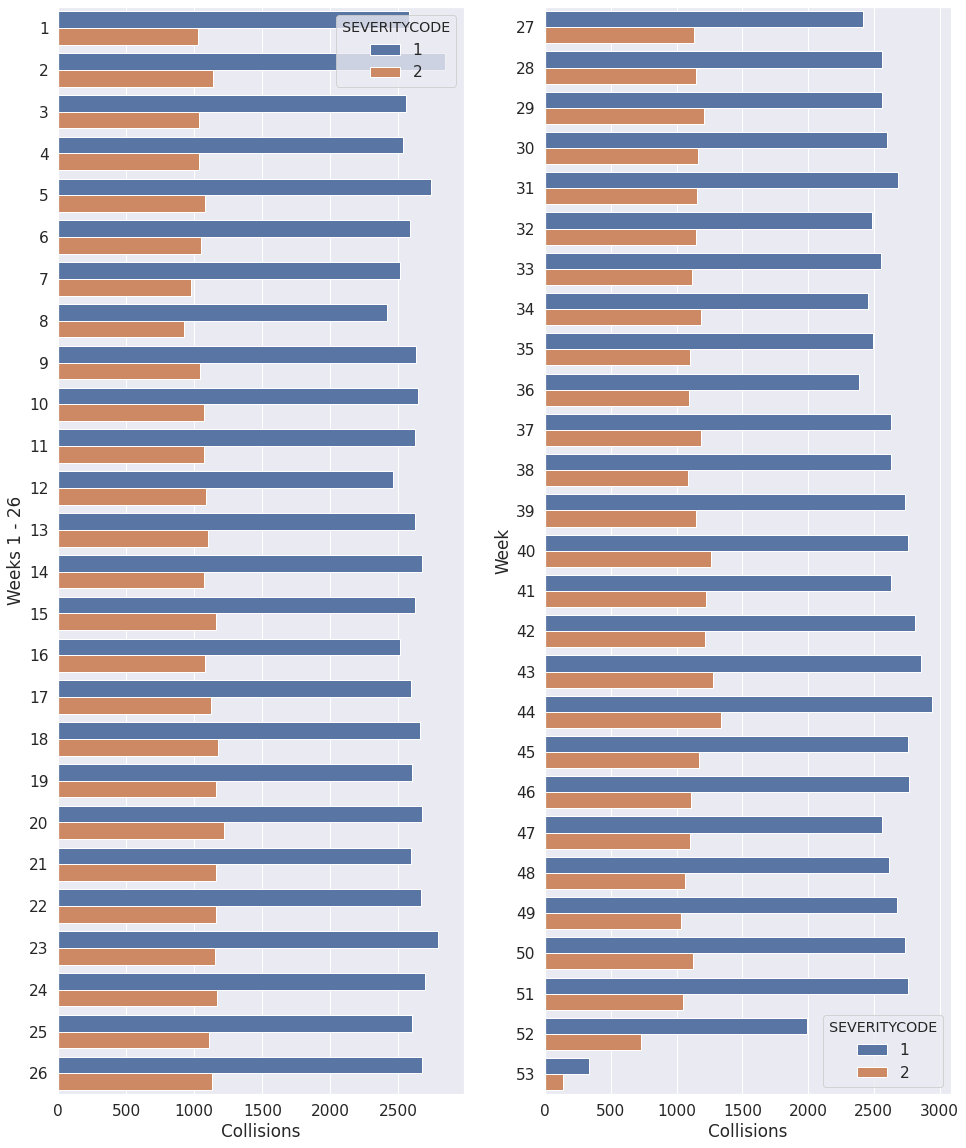

In [210]:
fig, (ax5, ax6) = plt.subplots(1, 2, figsize = (16, 20))
sns.countplot(y="YEARWEEK", hue="SEVERITYCODE", data=df_explore[(df_explore.YEARWEEK <= 26)], ax=ax5)
ax5.set(xlabel='Collisions', ylabel="Weeks 1 - 26")
sns.countplot(y="YEARWEEK", hue="SEVERITYCODE", data=df_explore[(df_explore.YEARWEEK > 26)], ax=ax6)
ax6.set(xlabel='Collisions', ylabel="Week")

## Situational Conditions - Weather, Road, Light

In [249]:
df_explore = df[['SEVERITYCODE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']].copy()

In [250]:
df_explore['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [251]:
df_explore['ROADCOND'].unique()

array(['Wet', 'Dry', nan, 'Unknown', 'Snow/Slush', 'Ice', 'Other',
       'Sand/Mud/Dirt', 'Standing Water', 'Oil'], dtype=object)

In [138]:
df_explore['LIGHTCOND'].unique()

array(['Daylight', 'Dark - Street Lights On', 'Dark - No Street Lights',
       nan, 'Unknown', 'Dusk', 'Dawn', 'Dark - Street Lights Off',
       'Other', 'Dark - Unknown Lighting'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='WEATHER'>

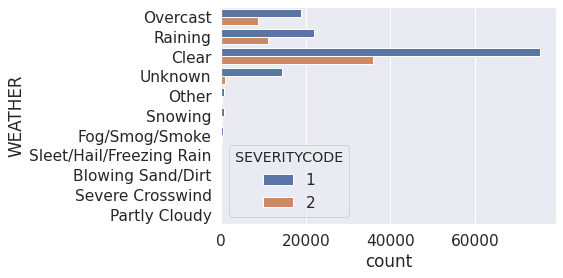

In [252]:
sns.countplot(y="WEATHER", hue="SEVERITYCODE", data=df_explore)

For weather we keep overcast, raining, clear and unknown.  Everything else is not relavent.

<AxesSubplot:xlabel='count', ylabel='ROADCOND'>

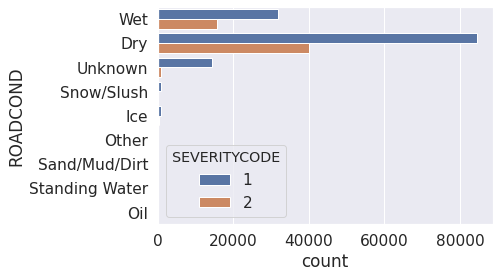

In [253]:
sns.countplot(y="ROADCOND", hue="SEVERITYCODE", data=df_explore)

For road condition keep wet, dry and unknown.

<AxesSubplot:xlabel='count', ylabel='LIGHTCOND'>

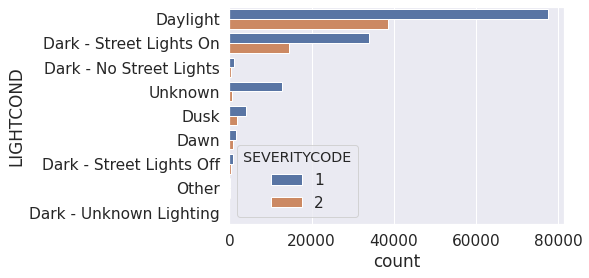

In [254]:
sns.countplot(y="LIGHTCOND", hue="SEVERITYCODE", data=df_explore)

For light condition keep daylight, dark with street lights on, dusk and unknown.

## Counts - VEHCOUNT, PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT

In [49]:
df_explore = df[['SEVERITYCODE','VEHCOUNT','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT']].copy()

In [51]:
df_explore['VEHCOUNT'].unique()

array([ 2,  3,  1,  0,  4,  7,  5,  6,  8, 11,  9, 10, 12])

In [52]:
df_explore['PERSONCOUNT'].unique()

array([ 2,  4,  3,  0,  1,  5,  6, 16,  8,  7, 11,  9, 12, 17, 26, 22, 10,
       37, 13, 36, 28, 14, 53, 19, 30, 29, 23, 44, 15, 32, 21, 41, 27, 20,
       35, 43, 81, 18, 25, 48, 24, 34, 57, 39, 47, 54, 31])

In [53]:
df_explore['PEDCOUNT'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [54]:
df_explore['PEDCYLCOUNT'].unique()

array([0, 1, 2])

In [55]:
corr = df_explore.corr()
cm = sns.light_palette("green", as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

,SEVERITYCODE,VEHCOUNT,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT
SEVERITYCODE,1.00,-0.05,0.13,0.25,0.21
VEHCOUNT,-0.05,1.00,0.38,-0.26,-0.25
PERSONCOUNT,0.13,0.38,1.00,-0.02,-0.04
PEDCOUNT,0.25,-0.26,-0.02,1.00,-0.02
PEDCYLCOUNT,0.21,-0.25,-0.04,-0.02,1.00


[Text(0.5, 0, 'Collisions'), Text(0, 0.5, 'Cyclist Count')]

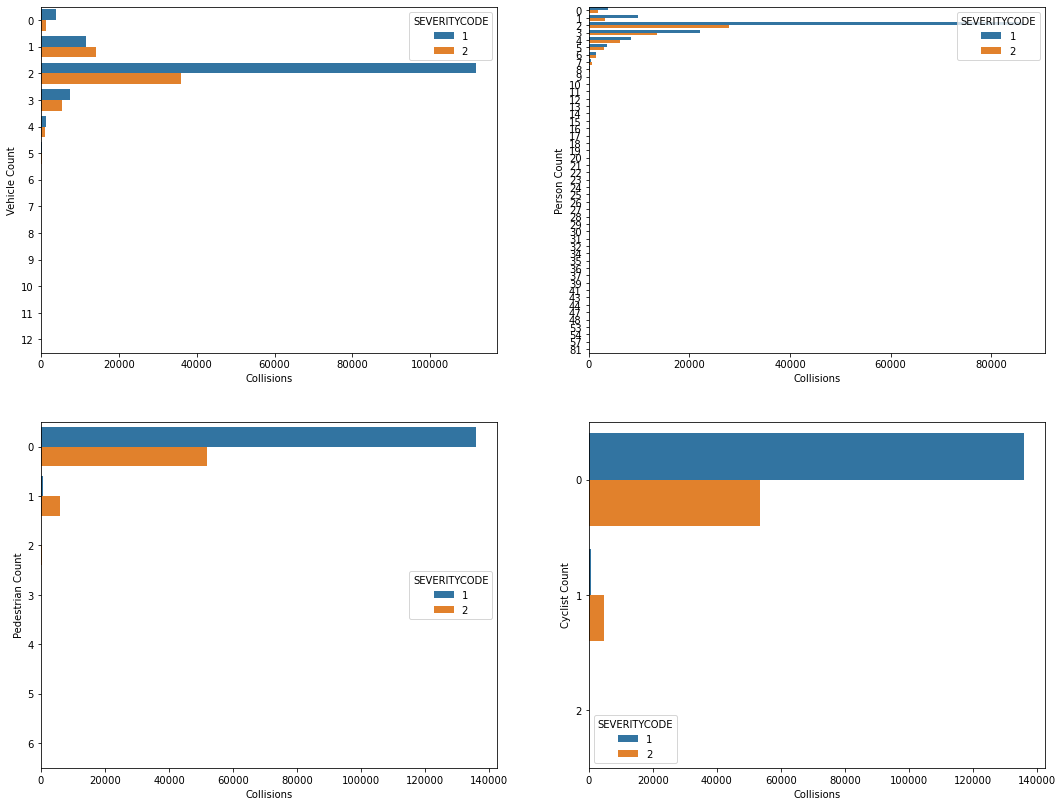

In [56]:
fig, ax = plt.subplots(2,2, figsize = (18, 14))
ax1, ax2, ax3, ax4 = ax.flatten()

sns.countplot(y="VEHCOUNT", hue="SEVERITYCODE", data=df_explore, ax=ax1)
ax1.set(xlabel='Collisions', ylabel='Vehicle Count')

sns.countplot(y="PERSONCOUNT", hue="SEVERITYCODE", data=df_explore, ax=ax2)
ax2.set(xlabel='Collisions', ylabel='Person Count')

sns.countplot(y="PEDCOUNT", hue="SEVERITYCODE", data=df_explore, ax=ax3)
ax3.set(xlabel='Collisions', ylabel="Pedestrian Count")

sns.countplot(y="PEDCYLCOUNT", hue="SEVERITYCODE", data=df_explore, ax=ax4)
ax4.set(xlabel='Collisions', ylabel="Cyclist Count")

Person distribution is way off.  Side bar - there was a huge bus accident which had the 81 people involved, that was a single crash.  In any case this need to be adjusted for modeling.  Consider categorizing these resampling.  Same with vehicle count but this is not as bad.  While walkers and bike riders are almost certain to have an injury involved there are a minimum number of these so not a good candidate, try it out though.  

## Human Factors - INATTENTIONIND, UNDERINFL

There is a lot of distracted drivers causing accidents.  There is some correlation with both so these are candidates.

In [18]:
df_explore = df[['SEVERITYCODE','INATTENTIONIND','UNDERINFL']].copy()

In [19]:
df_explore['INATTENTIONIND'].unique()

array([nan, 'Y'], dtype=object)

In [20]:
df_explore['UNDERINFL'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [21]:
df_explore[['UNDERINFL','INATTENTIONIND']] = df_explore[['UNDERINFL','INATTENTIONIND']].replace(['Y','1', 1.0], 1)
df_explore['UNDERINFL'] = df_explore['UNDERINFL'].replace(['N','0', 0.0], 0)
df_explore['INATTENTIONIND'] = df_explore['INATTENTIONIND'].replace(np.nan, 0)
df_explore['UNDERINFL'] = df_explore['UNDERINFL'].replace(np.nan, 0)

In [27]:
df_explore['INATTENTIONIND'].value_counts()

0.0    164868
1.0     29805
Name: INATTENTIONIND, dtype: int64

In [28]:
df_explore['UNDERINFL'].value_counts()

0.0    185552
1.0      9121
Name: UNDERINFL, dtype: int64

In [22]:
corr = df_explore.corr()
cm = sns.light_palette("green", as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

,SEVERITYCODE,INATTENTIONIND,UNDERINFL
SEVERITYCODE,1.00,0.05,0.04
INATTENTIONIND,0.05,1.00,-0.03
UNDERINFL,0.04,-0.03,1.00


[Text(0.5, 0, 'Collisions'), Text(0, 0.5, 'Intoxicated Driver')]

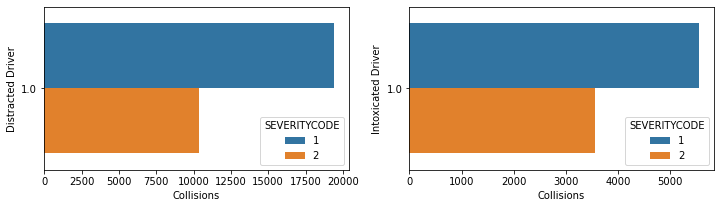

In [26]:
fig, ax = plt.subplots(1,2, figsize = (12, 3))
ax1, ax2 = ax.flatten()

# Plot when the driver is distracted
sns.countplot(y="INATTENTIONIND", hue="SEVERITYCODE", data=df_explore[(df_explore.INATTENTIONIND == 1)], ax=ax1)
ax1.set(xlabel='Collisions', ylabel="Distracted Driver")

# Plot when driver is intoxicated
sns.countplot(y="UNDERINFL", hue="SEVERITYCODE", data=df_explore[(df_explore.UNDERINFL ==1)], ax=ax2)
ax2.set(xlabel='Collisions', ylabel="Intoxicated Driver")

## Collision Descriptors

['Angles' 'Sideswipe' 'Parked Car' 'Other' 'Cycles' 'Rear Ended' 'Head On'
 nan 'Left Turn' 'Pedestrian' 'Right Turn']


<AxesSubplot:xlabel='COLLISIONTYPE', ylabel='count'>

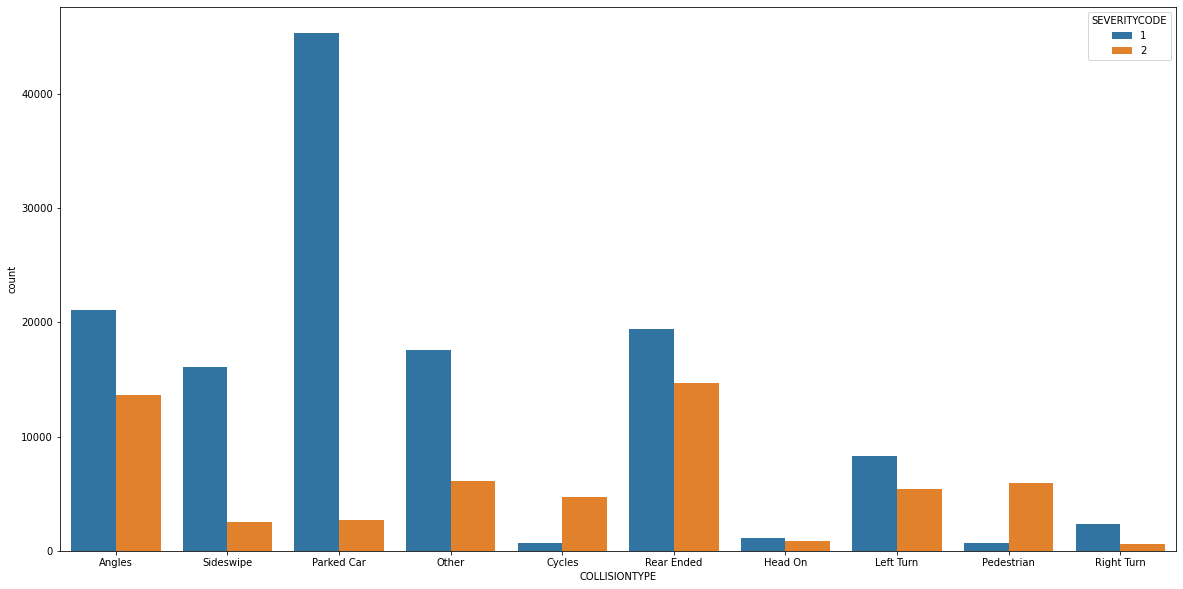

In [104]:
# These are a superset of SDOT collision types.  Also overlap with HITPARKEDCAR.
print(df['COLLISIONTYPE'].unique())
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x="COLLISIONTYPE", hue="SEVERITYCODE", data=df, ax=ax)

[nan 'Y']


<AxesSubplot:xlabel='count', ylabel='SPEEDING'>

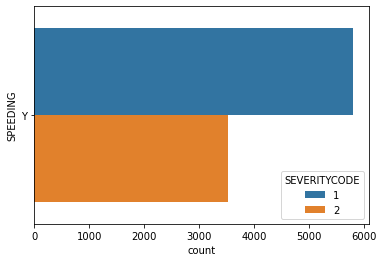

In [101]:
# Surprising there is not more speeding, but when there is there a good chance of injury
print(df['SPEEDING'].unique())
sns.countplot(y="SPEEDING", hue="SEVERITYCODE", data=df)

['N' 'Y']
N    187457
Y      7216
Name: HITPARKEDCAR, dtype: int64


<AxesSubplot:xlabel='count', ylabel='HITPARKEDCAR'>

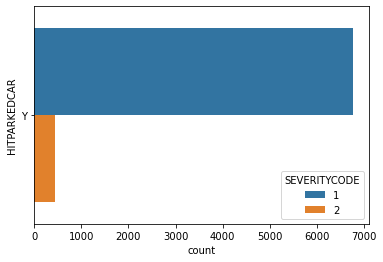

In [64]:
# When hitting a parked car there is little chance of injury
print(df['HITPARKEDCAR'].unique())
print(df['HITPARKEDCAR'].value_counts())
sns.countplot(y="HITPARKEDCAR", hue="SEVERITYCODE", data=df[(df.HITPARKEDCAR == 'Y')])

[nan 'Y']
Y    4667
Name: PEDROWNOTGRNT, dtype: int64


<AxesSubplot:xlabel='count', ylabel='PEDROWNOTGRNT'>

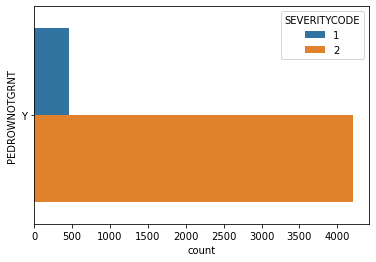

In [103]:
# When a pedestrian is not given right of way this is usually an injury
print(df['PEDROWNOTGRNT'].unique())
print(df['PEDROWNOTGRNT'].value_counts())
sns.countplot(y="PEDROWNOTGRNT", hue="SEVERITYCODE", data=df)

[11 16 14 51 13 26 28 18 34  0 24 69 12 21 23 29 27 48 15 55 33 56 54 31
 44 32 25 66 36 64 22 58 47 61 35 53 46 68 52]


<AxesSubplot:xlabel='SDOT_COLCODE', ylabel='count'>

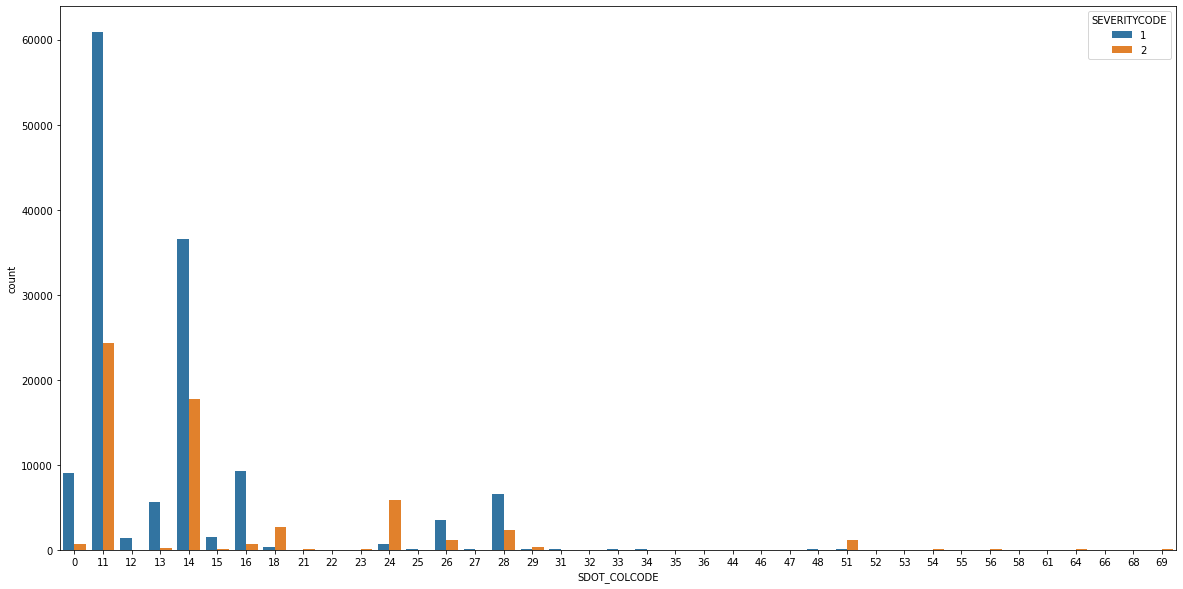

In [86]:
print(df['SDOT_COLCODE'].unique())
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x="SDOT_COLCODE", hue="SEVERITYCODE", data=df, ax=ax)
#sns.violinplot(df['SDOT_COLCODE'], ax=ax)

In [102]:
# SDOT and Washington State collision codes are different but representing the same thing.  So much for standardization.
# Use the SDOT codes only, do not use the state ones
df[{'SDOT_COLDESC','ST_COLDESC'}]

,SDOT_COLDESC,ST_COLDESC
0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Entering at angle
1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",From same direction - both going straight - bo...
2,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",One parked--one moving
3,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",From same direction - all others
4,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",Entering at angle
...,...,...
194668,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",From opposite direction - both moving - head-on
194669,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",From same direction - both going straight - bo...
194670,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",From opposite direction - one left turn - one ...
194671,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,Vehicle Strikes Pedalcyclist


In [93]:
# Not a clue what these are and no info to be found, not worth investigating
print(df['SEGLANEKEY'].unique())
print(df['SEGLANEKEY'].value_counts())

[    0  6855 25242 ... 11583 10319 45880]
0         191907
6532          19
6078          16
12162         15
10336         14
           ...  
35157          1
10817          1
15043          1
525169         1
16376          1
Name: SEGLANEKEY, Length: 1955, dtype: int64


## Data Understsanding Wrap-Up

Based on analysis of the data set we conclude the following attributes will make it into the model as features.
- Severity
    - **SEVERITYCODE**
    - ~~**SEVERITYDESC**~~ - nothing of value here
- Location, Time
    - ~~**INCDATE**~~ - out, this is redundant
    - ~~**INCDTTM**~~ - out, all date parts are not helpful to the model
    - ~~**X**~~ - out, these could be helpful for additional info but not for this study
    - ~~**Y**~~ - out, same as above
    - ~~**LOCATION**~~ - out, while containing a lot of detail is too complex to handle for this study
    - **ADDRTYPE** - in, one of the better features with solid correlation 
    - **JUNCTIONTYPE** - in, another good feature with solid correlation
    - ~~**INTKEY**~~ - out, this is key
    - ~~**CROSSWALKKEY**~~ - out, is key but has correlation to severity
- Situational Conditions
    - **WEATHER** - in, dropping most of the categories
    - **ROADCOND** - in, dropping most of the categories
    - **LIGHTCOND** - in, dropping most of the categories
- Counts
    - **VEHCOUNT** - in, there is some correlation here but need to consider overfitting
    - **PERSONCOUNT** - in, there are plenty of outliers here, clean-up needed
    - ~~**PEDCOUNT**~~ -  out, there is correlation here but not enough to sway the prediction
    - ~~**PEDCYLCOUNT**~~ - out, there is correlation here but not enough to sway the prediction
- Human Factors
    - **INATTENTIONIND** - in, not a strong correlation but helpful
    - **UNDERINFL** - in, not a strong correlation but helpful
- Collision Descriptors
    - **COLLISIONTYPE** - in, good correlation keep all of the categories here
    - **SPEEDING** - in, there's not a lot here but there is a correlation
    - ~~**SEGLANEKEY**~~ - out, there's no info on what these are does not help with severity
    - **HITPARKEDCAR** - in, helps with severity, it's not as severe when a parked car is involved
    - **PEDROWNOTGRNT** - in, there's almost always an injury when this is set
    - **SDOTCOLNUM** - out, key
    - ~~**SDOT_COLCODE**~~ - in, SDOT code used to describe the collision
    - ~~**SDOT_COLDESC**~~ - out, no need for the description
    - ~~**ST_COLCODE**~~ - out, overlap with SDOT_COLCODE
    - ~~**ST_COLDESC**~~


# Data Preparation

In [129]:
# Get a fresh read on the data file
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv",\
                low_memory = False)
print('File downloaded')

File downloaded


In [130]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [131]:
df.drop(columns=['X','Y','OBJECTID','INCKEY','COLDETKEY','REPORTNO','STATUS','INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC'
                      ,'SEVERITYCODE.1','SEVERITYDESC','INCDATE','SDOT_COLDESC','SDOTCOLNUM','ST_COLDESC','SEGLANEKEY',
                      'CROSSWALKKEY', 'PEDCOUNT','PEDCYLCOUNT','INCDTTM','ST_COLCODE','LOCATION'],inplace=True)

In [132]:
df["SEVERITYCODE"]=df["SEVERITYCODE"].apply(lambda x : 0 if x==1 else 1)
df["HITPARKEDCAR"]=df["HITPARKEDCAR"].apply(lambda x : 1 if x=="Y" else 0)
df["PEDROWNOTGRNT"]=df["PEDROWNOTGRNT"].apply(lambda x : 1 if x=="Y" else 0)
df["SPEEDING"]=df["SPEEDING"].apply(lambda x : 1 if x=="Y" else 0)
df["INATTENTIONIND"]=df["INATTENTIONIND"].apply(lambda x : 1 if x=="Y" else 0)
df["UNDERINFL"]=df["UNDERINFL"].fillna(0).apply(lambda x : 1 if x =='Y' else (0 if x == 'N' else int(x)))
#df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
#df['SDOT_COLCODE'] = df['SDOT_COLCODE'].fillna('0.0').astype('float64')

In [156]:
df_features = df.copy()

In [157]:
df_features.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT',
       'JUNCTIONTYPE', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING',
       'HITPARKEDCAR'],
      dtype='object')

In [158]:
df_features["WEATHER"]= df_features["WEATHER"].apply(lambda x: "OVERCAST" if x == "Overcast" else ("RAINING" if x == "Raining" else
                                                                ("CLEAR" if x == "Clear" else ("UNKNOWN" if x =="Unknown" else
                                                                                              "NOISE" ))))

In [159]:
df_features["ROADCOND"]= df_features["ROADCOND"].apply(lambda x: "DRY" if x == "Dry" else ("WET" if x == "Wet" else
                                                                 ("UNKNOWN" if x =="Unknown" else
                                                                                              "NOISE" )))

In [160]:
df_features["LIGHTCOND"]= df_features["LIGHTCOND"].apply(lambda x: "DAYLIGHT" if x == "Daylight" else ("DARK-STREET-LIGHTS-ON" if x == "Dark - Street Lights On" else
                                                                ("UNKNOWN" if x == "Unknown" else ("DUSK" if x =="Dusk" else
                                                                                              "NOISE" ))))

In [161]:
df_features["JUNCTIONTYPE"]= df_features["JUNCTIONTYPE"].apply(lambda x: "MID-BLOCK-UNRELATED" if x == "Mid-Block (not related to intersection)" else ("INTERSECTION-RELATED" if x == "At Intersection (intersection related)" else
                                                                ("MID-BLOCK-RELATED" if x == "Mid-Block (but intersection related)" else ("DRIVEWAY" if x =="Driveway Junction" else
                                                                                              "NOISE" ))))

In [162]:
df_features["ADDRTYPE"]=df_features["ADDRTYPE"].apply(lambda x : 0 if x=='Block' else 1)
#df_features['ADDRTYPE'] = \
#df_features['ADDRTYPE'].fillna('Block').replace(\
#                                       ['Alley', 'Block', 'Intersection'], ['0', '1', '1']).astype('float64')

In [163]:
df_features['COLLISIONTYPE'] = \
df_features['COLLISIONTYPE'].fillna('Other').replace(\
                                            ['Angles','Cycles','Head On', 'Left Turn', 'Other', 'Parked Car',\
                                             'Pedestrian', 'Rear Ended', 'Right Turn', 'Sideswipe'],\
                                            ['0','1','2','3','4','5','6','7','8','9']).astype('float64')

In [164]:
df_features.isnull().sum()

SEVERITYCODE      0
ADDRTYPE          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
JUNCTIONTYPE      0
SDOT_COLCODE      0
INATTENTIONIND    0
UNDERINFL         0
WEATHER           0
ROADCOND          0
LIGHTCOND         0
PEDROWNOTGRNT     0
SPEEDING          0
HITPARKEDCAR      0
dtype: int64

In [165]:
#df_features.dropna(subset = ["ADDRTYPE","LOCATION","COLLISIONTYPE","JUNCTIONTYPE","WEATHER","ROADCOND",\
#                    "LIGHTCOND","ST_COLCODE"], inplace=True)

In [166]:
#df_features.isnull().sum()

In [167]:
# One Hot Encoding
df_features = pd.get_dummies(df_features,columns=['WEATHER','COLLISIONTYPE','JUNCTIONTYPE',\
                                                  'ROADCOND','LIGHTCOND'])

In [168]:
df_features.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'SDOT_COLCODE',
       'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING',
       'HITPARKEDCAR', 'WEATHER_CLEAR', 'WEATHER_NOISE', 'WEATHER_OVERCAST',
       'WEATHER_RAINING', 'WEATHER_UNKNOWN', 'COLLISIONTYPE_0.0',
       'COLLISIONTYPE_1.0', 'COLLISIONTYPE_2.0', 'COLLISIONTYPE_3.0',
       'COLLISIONTYPE_4.0', 'COLLISIONTYPE_5.0', 'COLLISIONTYPE_6.0',
       'COLLISIONTYPE_7.0', 'COLLISIONTYPE_8.0', 'COLLISIONTYPE_9.0',
       'JUNCTIONTYPE_DRIVEWAY', 'JUNCTIONTYPE_INTERSECTION-RELATED',
       'JUNCTIONTYPE_MID-BLOCK-RELATED', 'JUNCTIONTYPE_MID-BLOCK-UNRELATED',
       'JUNCTIONTYPE_NOISE', 'ROADCOND_DRY', 'ROADCOND_NOISE',
       'ROADCOND_UNKNOWN', 'ROADCOND_WET', 'LIGHTCOND_DARK-STREET-LIGHTS-ON',
       'LIGHTCOND_DAYLIGHT', 'LIGHTCOND_DUSK', 'LIGHTCOND_NOISE',
       'LIGHTCOND_UNKNOWN'],
      dtype='object')

In [169]:
# Remove the noise
df_features.drop(columns=["JUNCTIONTYPE_NOISE", "LIGHTCOND_NOISE","ROADCOND_NOISE",\
                          "WEATHER_NOISE"],axis=1,inplace=True)

In [170]:
df_features.head()

,SEVERITYCODE,ADDRTYPE,PERSONCOUNT,VEHCOUNT,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,...,JUNCTIONTYPE_INTERSECTION-RELATED,JUNCTIONTYPE_MID-BLOCK-RELATED,JUNCTIONTYPE_MID-BLOCK-UNRELATED,ROADCOND_DRY,ROADCOND_UNKNOWN,ROADCOND_WET,LIGHTCOND_DARK-STREET-LIGHTS-ON,LIGHTCOND_DAYLIGHT,LIGHTCOND_DUSK,LIGHTCOND_UNKNOWN
0,1,1.0,2,2,11,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,1.0,2,2,16,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2,0,1.0,4,3,14,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,0,1.0,3,3,11,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
4,1,1.0,2,2,11,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [186]:
df_features.columns.values

array(['SEVERITYCODE', 'ADDRTYPE', 'PERSONCOUNT', 'VEHCOUNT',
       'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT',
       'SPEEDING', 'HITPARKEDCAR', 'WEATHER_CLEAR', 'WEATHER_OVERCAST',
       'WEATHER_RAINING', 'WEATHER_UNKNOWN', 'COLLISIONTYPE_0.0',
       'COLLISIONTYPE_1.0', 'COLLISIONTYPE_2.0', 'COLLISIONTYPE_3.0',
       'COLLISIONTYPE_4.0', 'COLLISIONTYPE_5.0', 'COLLISIONTYPE_6.0',
       'COLLISIONTYPE_7.0', 'COLLISIONTYPE_8.0', 'COLLISIONTYPE_9.0',
       'JUNCTIONTYPE_DRIVEWAY', 'JUNCTIONTYPE_INTERSECTION-RELATED',
       'JUNCTIONTYPE_MID-BLOCK-RELATED',
       'JUNCTIONTYPE_MID-BLOCK-UNRELATED', 'ROADCOND_DRY',
       'ROADCOND_UNKNOWN', 'ROADCOND_WET',
       'LIGHTCOND_DARK-STREET-LIGHTS-ON', 'LIGHTCOND_DAYLIGHT',
       'LIGHTCOND_DUSK', 'LIGHTCOND_UNKNOWN'], dtype=object)

In [187]:
X_unbalanced = df_features[['ADDRTYPE', 'PERSONCOUNT', 'VEHCOUNT',
       'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT',
       'SPEEDING', 'HITPARKEDCAR', 'WEATHER_CLEAR', 'WEATHER_OVERCAST',
       'WEATHER_RAINING', 'WEATHER_UNKNOWN', 'COLLISIONTYPE_0.0',
       'COLLISIONTYPE_1.0', 'COLLISIONTYPE_2.0', 'COLLISIONTYPE_3.0',
       'COLLISIONTYPE_4.0', 'COLLISIONTYPE_5.0', 'COLLISIONTYPE_6.0',
       'COLLISIONTYPE_7.0', 'COLLISIONTYPE_8.0', 'COLLISIONTYPE_9.0',
       'JUNCTIONTYPE_DRIVEWAY', 'JUNCTIONTYPE_INTERSECTION-RELATED',
       'JUNCTIONTYPE_MID-BLOCK-RELATED',
       'JUNCTIONTYPE_MID-BLOCK-UNRELATED', 'ROADCOND_DRY',
       'ROADCOND_UNKNOWN', 'ROADCOND_WET',
       'LIGHTCOND_DARK-STREET-LIGHTS-ON', 'LIGHTCOND_DAYLIGHT',
       'LIGHTCOND_DUSK', 'LIGHTCOND_UNKNOWN']]
y_unbalanced = df_features['SEVERITYCODE']

Use random under sampling method balance severity.  RUS randomly removes samples from the majority class (SEVERITYCODE == 1) to equal the minority class (SEVERITYCODE == 2).  The balancing has a significant effect on all of the models used below.  Without using this Decision Tree, KNN, Logistics Regression and Random Forest do not perform well at all.  On the other hand XGBoost and GBT positive weight parameters are don't make a difference so it levels the playing field.  Without balancing XGB and GBT perform very well but we balance per the requirements and allow for all of the classifiers to have a shot at being the best at predicting severity == injury.

In [188]:
RUS = RandomUnderSampler(random_state=12)
X, y = RUS.fit_resample(X_unbalanced, y_unbalanced)

print(X[0:5])
print(y.value_counts())

   ADDRTYPE  PERSONCOUNT  VEHCOUNT  SDOT_COLCODE  INATTENTIONIND  UNDERINFL  \
0       1.0            3         3            11               0          0   
1       1.0            0         2            11               0          0   
2       1.0            2         2            11               0          0   
3       1.0            1         0            14               0          0   
4       1.0            2         2            14               0          0   

   PEDROWNOTGRNT  SPEEDING  HITPARKEDCAR  WEATHER_CLEAR  ...  \
0              0         0             0              0  ...   
1              0         0             0              1  ...   
2              0         0             0              1  ...   
3              0         0             0              0  ...   
4              0         0             0              0  ...   

   JUNCTIONTYPE_INTERSECTION-RELATED  JUNCTIONTYPE_MID-BLOCK-RELATED  \
0                                  0                               0

# Modeling

In [189]:
# plot_confusion_matrix(y_test, XGB_yhat, XGB_model.classes_, title='XGBoost Confusion Matrix', accuracy=XGB_score_jac)
def plot_confusion_matrix(y_true, y_pred, labels, filename='', title='Confusion Matrix', accuracy=0.0, ymap=None, figsize=(6,4)):
    #https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    if accuracy == 0:
        ax.set_title(title, pad=10)
    else:
        ax.set_title(title + '\nAccuracy: ' + str(accuracy), pad=10)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    if len(filename) != 0:
        plt.savefig(filename)
    plt.show()

In [190]:
#df_features.dtypes

In [191]:
#X = df_features.copy()
#X.drop(['SEVERITYCODE'], axis=1, inplace=True)
#X[0:5]

In [192]:
#y = df_features['SEVERITYCODE'].values
#y[0:5]

In [193]:
X = preprocessing.StandardScaler().fit(X).transform(X)
#X[0:5]

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train Set:', X_train.shape,  y_train.shape)
print ('Test Set:', X_test.shape,  y_test.shape)

Train Set: (93100, 34) (93100,)
Test Set: (23276, 34) (23276,)


## XGBoost

In [195]:
# Tuning
#weight = int(y_train.value_counts()[0]/y_train.value_counts()[1])
#print(weight)

#parameters = {
#    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
#    "max_depth" : [3,4,5,6,8,10,12,15,20],
#    "min_child_weight": [1,3,5,7],
#    "gamma":[0.1,0.2,0.3,0.4],
#    "colsample_bytree":[0.3,0.4,0.5,0.7],
#    "scale_pos_weight":[2,2.2,2.5,2.7,2.9,3]
#}
#XGB_model = XGBClassifier()
#random_search = RandomizedSearchCV(XGB_model, param_distributions = parameters, n_iter = 5, n_jobs = -1,\
#                                   cv=5, verbose = 3, scoring = 'f1')
#random_search.fit(X_train, y_train)
#random_search.best_estimator_

In [196]:
scale_pos_weight = df_features[df_features.SEVERITYCODE==0]\
['SEVERITYCODE'].count()/df_features[df_features.SEVERITYCODE==1]['SEVERITYCODE'].count() 
scale_pos_weight

2.3455867189111155

Train Set Accuracy:  0.7196348012889366
              precision    recall  f1-score   support

           0       0.77      0.64      0.70     11638
           1       0.69      0.81      0.74     11638

    accuracy                           0.72     23276
   macro avg       0.73      0.72      0.72     23276
weighted avg       0.73      0.72      0.72     23276

f1 Score:  0.72
Jaccard Score:  0.72
Log Loss:  0.52


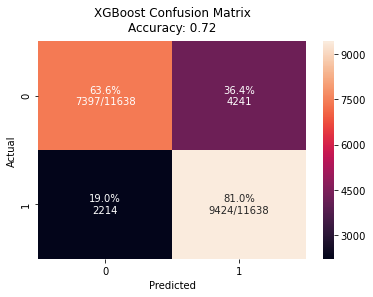

In [197]:
# Override weight based on optimization
#scale_pos_weight = 2.7
scale_pos_weight = 1
XGB_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=scale_pos_weight, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

XGB_model.fit(X_train, y_train)
XGB_yhat = XGB_model.predict(X_test)
XGB_yhat_prob = XGB_model.predict_proba(X_test)

XGB_score_jac = round(accuracy_score(y_test, XGB_yhat), 2)
XGB_score_f1 = round(f1_score(y_test, XGB_yhat, average='weighted'), 2)
XGB_score_ll = round(log_loss(y_test, XGB_yhat_prob), 2)

# Summary
print("Train Set Accuracy: ", metrics.accuracy_score(y_train, XGB_model.predict(X_train)))
print (classification_report(y_test, XGB_yhat))
print ("f1 Score: ", XGB_score_f1)
print ("Jaccard Score: ", XGB_score_jac)
print ("Log Loss: ", XGB_score_ll)

plot_confusion_matrix(y_test, XGB_yhat, XGB_model.classes_, title='XGBoost Confusion Matrix',\
                      accuracy=XGB_score_jac)

In [208]:
XGB_roc_auc = roc_auc_score(y_test, XGB_model.predict(X_test))
XGB_fpr, XGB_tpr, XGB_thresholds = roc_curve(y_test, XGB_model.predict_proba(X_test)[:,1])

## Gradient Boosting Trees

In [198]:
# GBT Tuning
#parameters = {'learning_rate': [0.15,0.1,0.05,0.01,0.005,0.001],
#              'subsample'    : [0.7,0.75,0.8,0.85,0.9,0.95,1],
#              'n_estimators' : [100,250,500,750,1000,1250,1500,1750],
#              'min_samples_split':[2,4,6,8,10,20,40,60,100],
#              'min_samples_leaf':[1,3,5,7,9],
#              'max_depth'    : [2,3,4,5,6,7]
#             }

#parameters = {'learning_rate': [0.15,0.1,0.05,0.01,0.005,0.001],
#              'n_estimators' : [100,250,500,750,1000,1250,1500,1750]
#             }

#tuning = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=4, min_samples_split = 2,\
#                                                           min_samples_leaf = 1, max_features = 'sqrt',\
#                                                           random_state = 10),\
#                      param_grid = parameters, scoring='accuracy', n_jobs=4, iid=False, cv=5)
#tuning.fit(X_train,y_train)
#tuning.grid_scores_, tuning.best_params_, tuning.best_score_

Train Set Accuracy:  0.7069602577873254
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     11638
           1       0.68      0.80      0.74     11638

    accuracy                           0.71     23276
   macro avg       0.72      0.71      0.71     23276
weighted avg       0.72      0.71      0.71     23276

f1 Score:  0.71
Jaccard Score:  0.71
Log Loss:  0.53


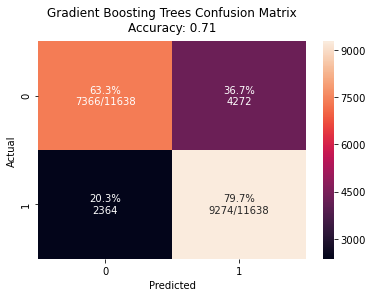

In [199]:
sample_weights = np.zeros(len(y_train))
#sample_weights[y_train == 0] = 0.2989
#sample_weights[y_train == 1] = 0.7011
sample_weights[y_train == 0] = 0.50
sample_weights[y_train == 1] = 0.50


GBT_model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, \
                                       random_state=0).fit(X_train, y_train, sample_weight=sample_weights)
GBT_yhat = GBT_model.predict(X_test)
GBT_yhat_prob = GBT_model.predict_proba(X_test)

GBT_score_jac = round(accuracy_score(y_test, GBT_yhat), 2)
GBT_score_f1 = round(f1_score(y_test, GBT_yhat, average='weighted'), 2)
GBT_score_ll = round(log_loss(y_test, GBT_yhat_prob), 2)

# Summary
print("Train Set Accuracy: ", metrics.accuracy_score(y_train, GBT_model.predict(X_train)))
print (classification_report(y_test, GBT_yhat))
print ("f1 Score: ", GBT_score_f1)
print ("Jaccard Score: ", GBT_score_jac)
print ("Log Loss: ", GBT_score_ll)

plot_confusion_matrix(y_test, GBT_yhat, GBT_model.classes_, title = 'Gradient Boosting Trees Confusion Matrix',\
                      accuracy = GBT_score_jac)

In [210]:
GBT_roc_auc = roc_auc_score(y_test, GBT_model.predict(X_test))
GBT_fpr, GBT_tpr, GBT_thresholds = roc_curve(y_test, GBT_model.predict_proba(X_test)[:,1])

## Logistic Regression

Train Set Accuracy:  0.7031041890440387
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     11638
           1       0.68      0.80      0.74     11638

    accuracy                           0.71     23276
   macro avg       0.72      0.71      0.71     23276
weighted avg       0.72      0.71      0.71     23276

f1 Score:  0.71
Jaccard Score:  0.71
Log Loss:  0.53


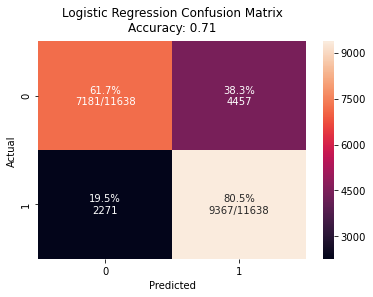

In [200]:
LR_model = LogisticRegression(C = 0.1, solver = 'liblinear', class_weight = 'balanced').fit(X_train, y_train)
LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)

LR_score_jac = round(accuracy_score(y_test, LR_yhat), 2)
LR_score_f1 = round(f1_score(y_test, LR_yhat, average = 'weighted'), 2)
LR_score_ll = round(log_loss(y_test, LR_yhat_prob), 2)

# Summary
print("Train Set Accuracy: ", metrics.accuracy_score(y_train, LR_model.predict(X_train)))
print (classification_report(y_test, LR_yhat))
print ("f1 Score: ", LR_score_f1)
print ("Jaccard Score: ", LR_score_jac)
print ("Log Loss: ", LR_score_ll)

plot_confusion_matrix(y_test, LR_yhat, LR_model.classes_, title = 'Logistic Regression Confusion Matrix',\
                      accuracy = LR_score_jac)

In [211]:
LR_roc_auc = roc_auc_score(y_test, LR_model.predict(X_test))
LR_fpr, LR_tpr, LR_thresholds = roc_curve(y_test, LR_model.predict_proba(X_test)[:,1])

## Random Forest

In [201]:
# Tuning
#parameters = {'n_estimators':[499,500,501]}
#             #'criterion':('gini'),
#             #'max_depth':[8,10]}
#            # 'max_features':('auto','sqrt')}
#            
#RF_model = RandomForestClassifier(n_jobs=-1, random_state=140, max_features='auto', max_depth=10)
#RF_grid = GridSearchCV(RF_model, param_grid=parameters, verbose=10, n_jobs=-1)
#RF_grid.fit(X_train,y_train)
#print(RF_grid.best_params_)
#print(RF_grid.best_score_)
#RF_grid_pred = RF_grid.predict(X_test)
#print(classification_report(y_test, RF_grid_pred))

Train Set Accuracy:  0.7190225563909775
              precision    recall  f1-score   support

           0       0.76      0.64      0.70     11638
           1       0.69      0.80      0.74     11638

    accuracy                           0.72     23276
   macro avg       0.73      0.72      0.72     23276
weighted avg       0.73      0.72      0.72     23276

f1 Score:  0.72
Jaccard Score:  0.72
Log Loss:  0.53


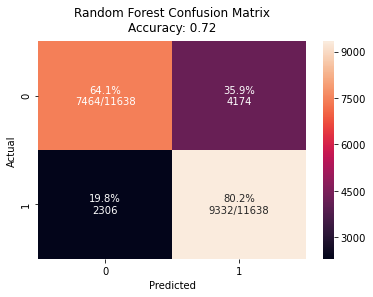

In [202]:
RF_model = RandomForestClassifier(n_estimators = 500, criterion = 'gini', n_jobs = -1,\
                                  random_state = 140, max_features = 'auto', max_depth=10)
RF_model.fit(X_train,y_train)
RF_yhat = RF_model.predict(X_test)
RF_yhat_prob = RF_model.predict_proba(X_test)

RF_score_jac = round(accuracy_score(y_test, RF_yhat), 2)
RF_score_f1 = round(f1_score(y_test, RF_yhat, average='weighted'), 2)
RF_score_ll = round(log_loss(y_test, RF_yhat_prob), 2)

# Summary
print("Train Set Accuracy: ", metrics.accuracy_score(y_train, RF_model.predict(X_train)))
print (classification_report(y_test, RF_yhat))
print ("f1 Score: ", RF_score_f1)
print ("Jaccard Score: ", RF_score_jac)
print ("Log Loss: ", RF_score_ll)

plot_confusion_matrix(y_test, RF_yhat, RF_model.classes_, title='Random Forest Confusion Matrix',\
                      accuracy = RF_score_jac)

In [212]:
RF_roc_auc = roc_auc_score(y_test, RF_model.predict(X_test))
RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_model.predict_proba(X_test)[:,1])

## k-Nearest Neighbors

In [ ]:
# Tuning
#Ks = 15
#Ks = 2
#mean_acc = np.zeros((Ks-1))
#std_acc = np.zeros((Ks-1))

#for n in range(1, Ks):
#    print("K -", n)
#    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
#    KNN_yhat = KNN_model.predict(X_test)
#    mean_acc[n-1] = metrics.accuracy_score(y_test, KNN_yhat)
#    std_acc[n-1] = np.std(KNN_yhat == y_test) / np.sqrt(KNN_yhat.shape[0])
#mean_acc
#print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax() + 1)
#plt.plot(range(1, Ks),mean_acc)
#plt.fill_between(range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
#plt.legend(('Accuracy ', '+/- 3xstd'))
#plt.ylabel('Accuracy')
#plt.xlabel('Neighbors')
#plt.tight_layout()
#plt.show()

Train Set Accuracy:  0.7147261009667024
              precision    recall  f1-score   support

           0       0.71      0.69      0.70     11638
           1       0.70      0.71      0.70     11638

    accuracy                           0.70     23276
   macro avg       0.70      0.70      0.70     23276
weighted avg       0.70      0.70      0.70     23276

f1 Score:  0.7
Jaccard Score:  0.7
Log Loss:  0.89


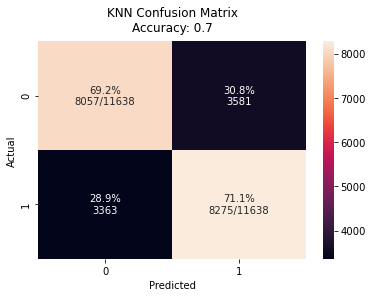

In [204]:
#k = mean_acc.argmax() + 1
k = 10
KNN_model = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
KNN_yhat = KNN_model.predict(X_test)
KNN_yhat_prob = KNN_model.predict_proba(X_test)

KNN_score_jac = round(accuracy_score(y_test, KNN_yhat), 2)
KNN_score_f1 = round(f1_score(y_test, KNN_yhat, average='weighted'), 2)
KNN_score_ll = round(log_loss(y_test, KNN_yhat_prob), 2)

# Summary
print("Train Set Accuracy: ", metrics.accuracy_score(y_train, KNN_model.predict(X_train)))
print (classification_report(y_test, KNN_yhat))
print ("f1 Score: ", KNN_score_f1)
print ("Jaccard Score: ", KNN_score_jac)
print ("Log Loss: ", KNN_score_ll)

plot_confusion_matrix(y_test, KNN_yhat, KNN_model.classes_, title = 'KNN Confusion Matrix',\
                      accuracy = KNN_score_jac)

In [213]:
KNN_roc_auc = roc_auc_score(y_test, KNN_model.predict(X_test))
KNN_fpr, KNN_tpr, KNN_thresholds = roc_curve(y_test, KNN_model.predict_proba(X_test)[:,1])

## Decision Tree

Train Set Accuracy:  0.699516648764769
              precision    recall  f1-score   support

           0       0.78      0.59      0.67     11638
           1       0.67      0.83      0.74     11638

    accuracy                           0.71     23276
   macro avg       0.72      0.71      0.70     23276
weighted avg       0.72      0.71      0.70     23276

f1 Score:  0.7
Jaccard Score:  0.71
Log Loss:  0.54


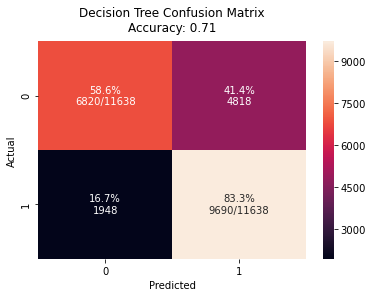

In [203]:
DT_model = DecisionTreeClassifier(criterion = "entropy", max_depth = 6)
DT_model.fit(X_train, y_train)
DT_yhat = DT_model.predict(X_test)
DT_yhat_prob = DT_model.predict_proba(X_test)

DT_score_jac = round(accuracy_score(y_test, DT_yhat), 2)
DT_score_f1 = round(f1_score(y_test, DT_yhat, average='weighted'), 2)
DT_score_ll = round(log_loss(y_test, DT_yhat_prob), 2)

# Summary
print("Train Set Accuracy: ", metrics.accuracy_score(y_train, DT_model.predict(X_train)))
print (classification_report(y_test, DT_yhat))
print ("f1 Score: ", DT_score_f1)
print ("Jaccard Score: ", DT_score_jac)
print ("Log Loss: ", DT_score_ll)

plot_confusion_matrix(y_test, DT_yhat, DT_model.classes_, title = 'Decision Tree Confusion Matrix',\
                      accuracy = DT_score_jac)

In [214]:
DT_roc_auc = roc_auc_score(y_test, DT_model.predict(X_test))
DT_fpr, DT_tpr, DT_thresholds = roc_curve(y_test, DT_model.predict_proba(X_test)[:,1])

# Evaluation

In [226]:
results = pd.DataFrame(np.array([['Gradient Boosting Trees', GBT_score_jac, GBT_score_f1, GBT_score_ll], \
                                 ['XGBoost', XGB_score_jac, XGB_score_f1, XGB_score_ll], \
                                 ['Random Forest', RF_score_jac, RF_score_f1, RF_score_ll], \
                                 ['Decision Tree', DT_score_jac, DT_score_f1, DT_score_ll], \
                                 ['k-Nearest Neighbors', KNN_score_jac, KNN_score_f1, KNN_score_ll], \
                                 ['Logistic Regression', LR_score_jac, LR_score_f1, LR_score_ll]]), \
                                columns=['Model', 'Jaccard Index', 'F1-Score', 'Log Loss'])
results

,Model,Jaccard Index,F1-Score,Log Loss
0,Gradient Boosting Trees,0.71,0.71,0.53
1,XGBoost,0.72,0.72,0.52
2,Random Forest,0.72,0.72,0.53
3,Decision Tree,0.71,0.7,0.54
4,k-Nearest Neighbors,0.7,0.7,0.89
5,Logistic Regression,0.71,0.71,0.53


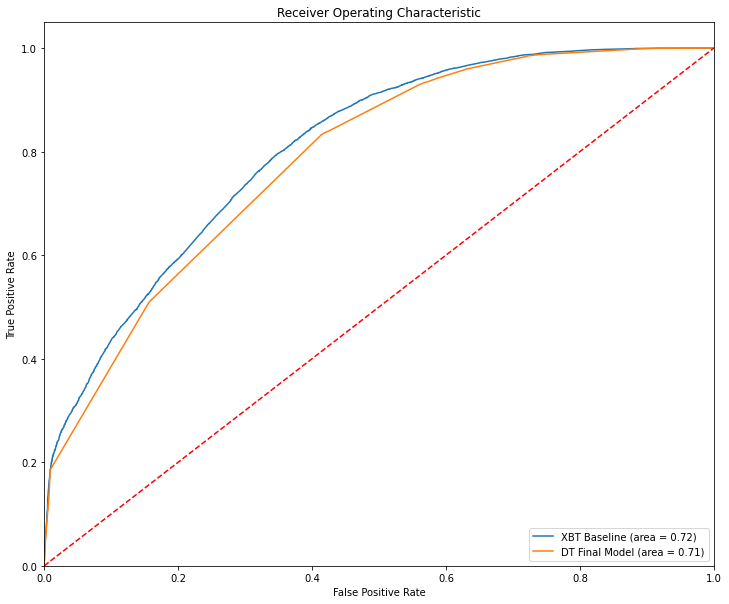

In [220]:
plt.figure(figsize=(12,10))
plt.plot(XGB_fpr, XGB_tpr, label='XBT Baseline (area = %0.2f)' % XGB_roc_auc)
#plt.plot(GBT_fpr, GBT_tpr, label='GBT Model 1 (area = %0.2f)' % GBT_roc_auc)
#plt.plot(LR_fpr, LR_tpr, label='LR Final Model (area = %0.2f)' % LR_roc_auc)
#plt.plot(RF_fpr, RF_tpr, label='RF Final Model (area = %0.2f)' % RF_roc_auc)
#plt.plot(KNN_fpr, KNN_tpr, label='KNN Final Model (area = %0.2f)' % KNN_roc_auc)
plt.plot(DT_fpr, DT_tpr, label='DT Final Model (area = %0.2f)' % DT_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()